In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/home/xhding/workspaces/torch-deep-retina')
import os
import scipy
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyret
from kinetic.evaluation import *
from kinetic.utils import *
from kinetic.config import get_custom_cfg
from kinetic.data import *
from kinetic.notebook.functions import *

In [6]:
with h5py.File('/home/xhding/tem_stim/20-09-15/fullfield_whitenoise.h5', 'r') as f:
    stimulus =  np.asarray(f['test']['stimulus'][:, 25, 25]).astype('float32')
    resp = np.asarray(f['test']['response']['firing_rate_10ms'][0])

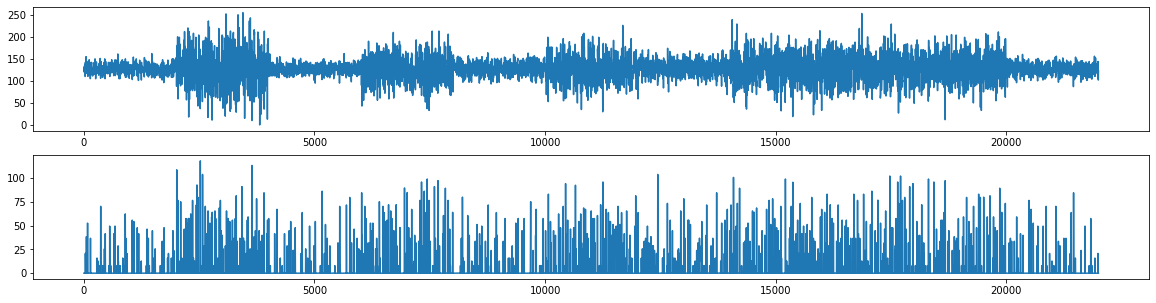

In [4]:
fig,ax = plt.subplots(2,1,figsize=(20,5))
ax[0].plot(stimulus)
ax[1].plot(resp)

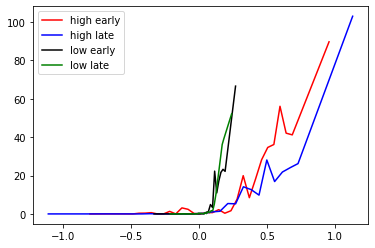

In [215]:
he, hl, le, ll = contrast_adaption_nonlinear(stimulus, resp, h_start=2000, l_start=4000)

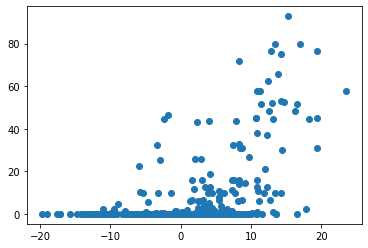

In [223]:
plt.plot(filtered_stim[filter_len:], resp_he[filter_len:], 'o')

In [3]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('LNK')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/LNK/epoch_045_loss_1.21_pearson_0.6026.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

LNK(
  (ln_filter): Temperal_Filter()
  (nonlinear): Sigmoid()
  (kinetics): Kinetics()
  (scale_shift): Linear(in_features=2, out_features=1, bias=True)
  (spiking): Softplus(beta=1, threshold=20)
)

In [4]:
test_data =  DataLoader(TestDatasetOnePixel(cfg, TrainDataset(cfg).stats), batch_size=1)
test_pc, pred, _ = pearsonr_eval_LNK_with_responses(model, test_data, device)
pred = np.pad(pred[:, 0], (100, 0), 'constant', constant_values=(0,0))

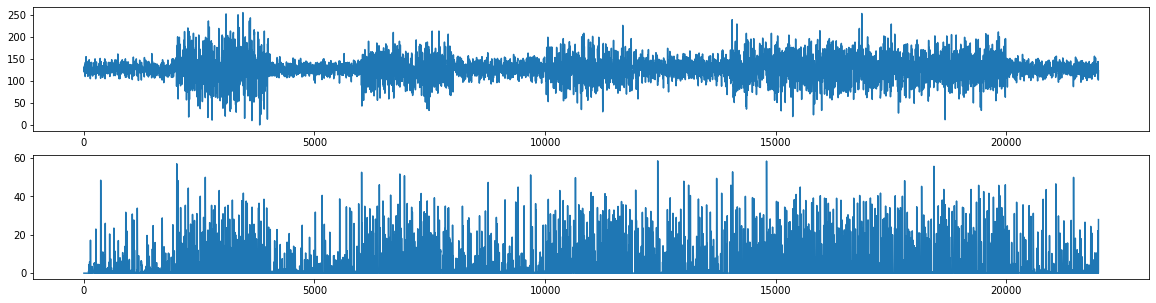

In [19]:
fig,ax = plt.subplots(2,1,figsize=(20,5))
ax[0].plot(stimulus)
ax[1].plot(pred)

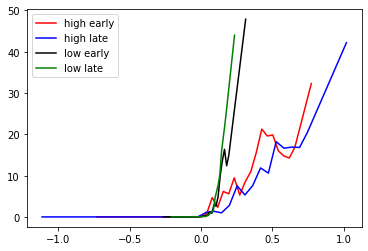

In [7]:
he, hl, le, ll = contrast_adaption_nonlinear(stimulus, pred, h_start=2000, l_start=4000)

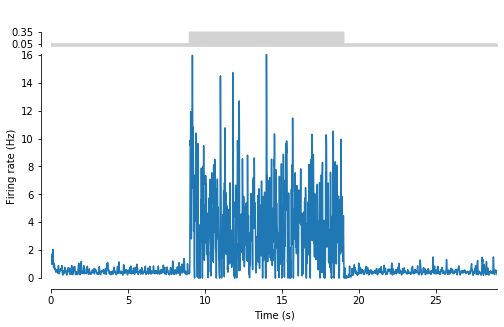

In [8]:
Rs, As, I1s, I2s, us = contrast_adaptation_LNK_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, filt_depth=100, n_repeats=10)

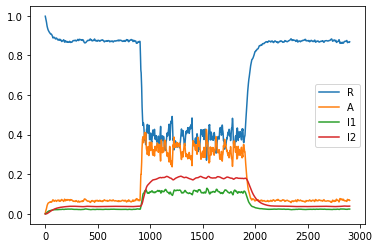

In [9]:
plt.plot(np.arange(2900),Rs[:], label='R')
plt.plot(np.arange(2900),As[:], label='A')
plt.plot(np.arange(2900),I1s[:], label='I1')
plt.plot(np.arange(2900),I2s[:], label='I2')
plt.legend()

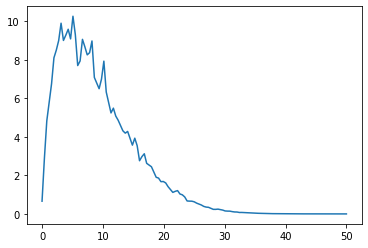

In [40]:
freq, power = scipy.signal.welch(resp, fs=100)
plt.plot(freq, power)

In [42]:
power.sum()/2

158.57023742634337

In [52]:
power[:21].sum()

163.00503990441658

7.039087454877219

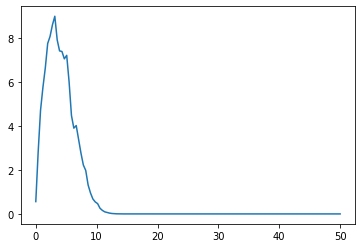

In [70]:
lp_filter = signal.firwin(25, 8, pass_zero='lowpass', fs=100)
freq, power = scipy.signal.welch(np.convolve(resp, lp_filter, 'valid'), fs=100)
plt.plot(freq, power)
np.convolve(resp, lp_filter, 'valid').std()

7.0064340246501775

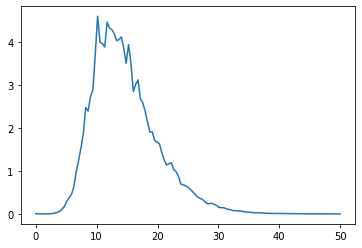

In [71]:
lp_filter = signal.firwin(25, 8, pass_zero='highpass', fs=100)
freq, power = scipy.signal.welch(np.convolve(resp, lp_filter, 'valid'), fs=100)
plt.plot(freq, power)
np.convolve(resp, lp_filter, 'valid').std()

In [85]:
torch.tensor(resp)[None, None,:].repeat(5,3,1).shape

torch.Size([5, 3, 22002])

In [86]:
y_targ = torch.tensor(resp)[None, None,:].repeat(5,3,1).to(device)
num_units = 3
numtaps = 25
f = 8
fs = 100
conv_filters = {}
for pass_zero in ['lowpass', 'highpass']:
    lp_filter = signal.firwin(numtaps, f, pass_zero=pass_zero, fs=fs)
    conv_filter = torch.nn.Conv1d(num_units, num_units, numtaps, groups=num_units, bias=False)
    conv_filter.weight.data = torch.from_numpy(np.flip(lp_filter).copy())[None, None, :].repeat(num_units, 1, 1)
    conv_filter.weight.requires_grad = False
    conv_filter = conv_filter.to(device)
    conv_filters[pass_zero] = conv_filter

y_targ_low = conv_filters['lowpass'](y_targ)
y_targ_high = conv_filters['highpass'](y_targ)

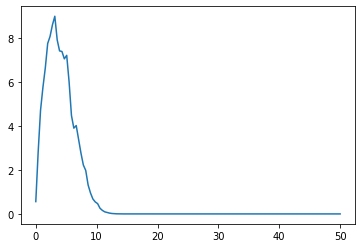

In [89]:
freq, power = scipy.signal.welch(y_targ_low.detach().cpu().numpy()[4,2,:], fs=100)
plt.plot(freq, power)

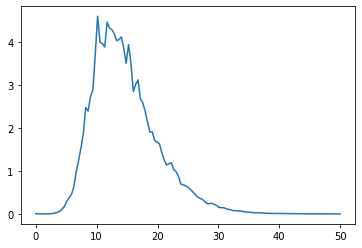

In [82]:
freq, power = scipy.signal.welch(y_targ_high.detach().cpu().numpy()[0,0,:], fs=100)
plt.plot(freq, power)

I20 = 0.03

In [122]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('LNK')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/LNK/epoch_045_loss_1.44_pearson_0.5106.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
checkpoint['model_state_dict']['bias']=torch.tensor([-8.6525], device='cuda:3')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

LNK(
  (ln_filter): Temperal_Filter()
  (nonlinear): Sigmoid()
  (kinetics): Kinetics()
  (scale_shift): Linear(in_features=1, out_features=1, bias=True)
  (spiking): Softplus(beta=1, threshold=20)
)

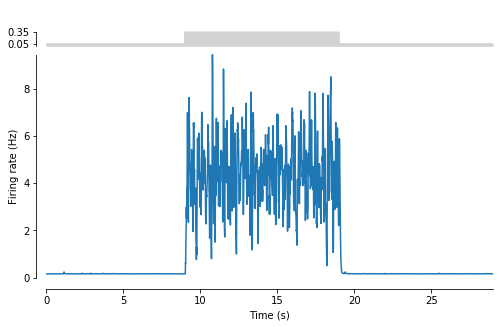

In [127]:
Rs, As, I1s, I2s, us = contrast_adaptation_LNK_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, filt_depth=100, I20=np.array([0.03]), n_repeats=10)

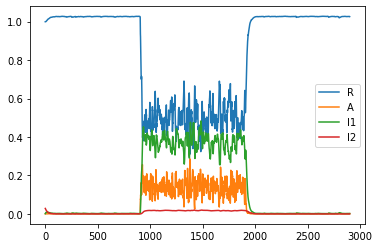

In [126]:
plt.plot(np.arange(2900),Rs[:], label='R')
plt.plot(np.arange(2900),As[:], label='A')
plt.plot(np.arange(2900),I1s[:], label='I1')
plt.plot(np.arange(2900),I2s[:], label='I2')
plt.legend()

I20=100

In [128]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('LNK')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/LNK/epoch_045_loss_1.25_pearson_0.5525.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
checkpoint['model_state_dict']['bias']=torch.tensor([-8.6525], device='cuda:3')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

LNK(
  (ln_filter): Temperal_Filter()
  (nonlinear): Sigmoid()
  (kinetics): Kinetics()
  (scale_shift): Linear(in_features=1, out_features=1, bias=True)
  (spiking): Softplus(beta=1, threshold=20)
)

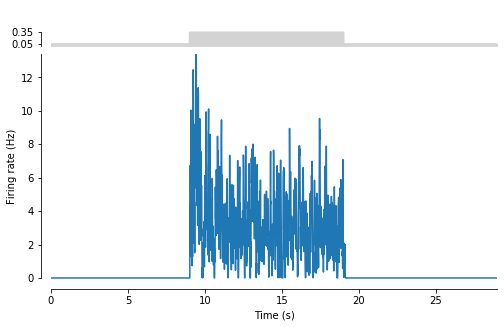

In [129]:
Rs, As, I1s, I2s, us = contrast_adaptation_LNK_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, filt_depth=100, I20=np.array([100.0]), n_repeats=10)

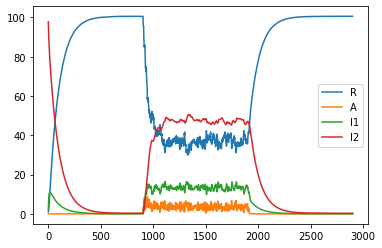

In [130]:
plt.plot(np.arange(2900),Rs[:], label='R')
plt.plot(np.arange(2900),As[:], label='A')
plt.plot(np.arange(2900),I1s[:], label='I1')
plt.plot(np.arange(2900),I2s[:], label='I2')
plt.legend()

In [137]:
test_data =  DataLoader(TestDatasetOnePixel(cfg, TrainDataset(cfg).stats), batch_size=1)
test_pc, pred, _ = pearsonr_eval_LNK_with_responses(model, test_data, device, I20=np.array([100.0]))
pred = np.pad(pred[:, 0], (100, 0), 'constant', constant_values=(0,0))

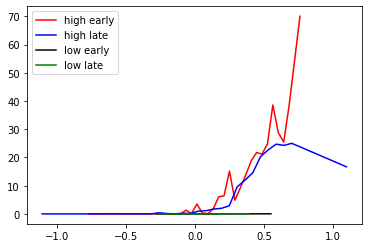

In [138]:
he, hl, le, ll = contrast_adaption_nonlinear(stimulus, pred, h_start=2000, l_start=4000)

train one pixel model only for slow parameters

In [139]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('one_pixel_norm_slow')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/one_pixel_channel/epoch_040_loss_1.75_pearson_0.3351.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsOnePixelChannel(
  (kinetics): Kinetics_channel()
  (amacrine_filter): Temperal_Filter()
  (ganglion): Sequential(
    (0): Linear(in_features=8, out_features=3, bias=False)
    (1): Softplus(beta=1, threshold=20)
  )
)

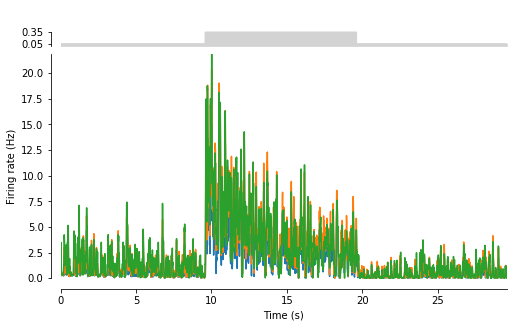

In [140]:
Rs, As, I1s, I2s, us, after_filters, after_amacrines = contrast_adaptation_onepixel_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, n_repeats=10)

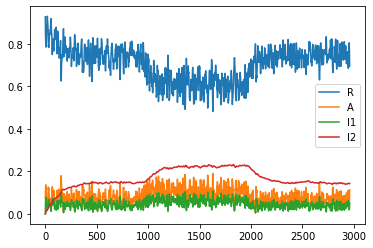

In [142]:
channel = 1
plt.plot(np.arange(2960),Rs[:,channel], label='R')
plt.plot(np.arange(2960),As[:,channel], label='A')
plt.plot(np.arange(2960),I1s[:,channel], label='I1')
plt.plot(np.arange(2960),I2s[:,channel], label='I2')
plt.legend()

In [157]:
test_data =  DataLoader(TestDatasetOnePixel(cfg, TrainDataset(cfg).stats), batch_size=1)
test_pc, pred, _ = pearsonr_eval_with_responses(model, test_data, 3, device)
pred = np.pad(pred, ((40, 0), (0,0)), 'constant', constant_values=(0,0))

0.4123603246293149

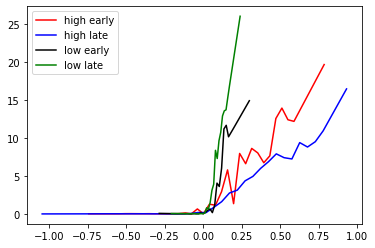

In [165]:
he, hl, le, ll = contrast_adaption_nonlinear(stimulus, pred[:, 0], h_start=2000, l_start=4000)

In [195]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('one_pixel_norm_slow')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/one_pixel_channel/epoch_045_loss_1.01_pearson_0.7028.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsOnePixelChannel(
  (kinetics): Kinetics_channel()
  (amacrine_filter): Temperal_Filter()
  (ganglion): Sequential(
    (0): Linear(in_features=8, out_features=3, bias=False)
    (1): Softplus(beta=1, threshold=20)
  )
)

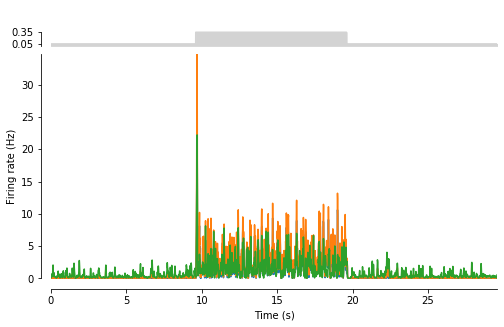

In [196]:
Rs, As, I1s, I2s, us, after_filters, after_amacrines = contrast_adaptation_onepixel_inspect(model, device, c0=0.05, c1=0.35, duration=1000, delay=1000, nsamples=3000, n_repeats=10)

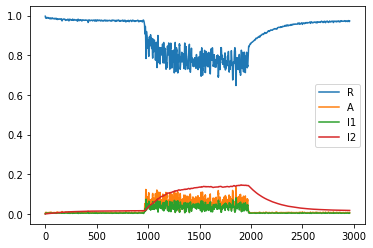

In [197]:
channel = 1
plt.plot(np.arange(2960),Rs[:,channel], label='R')
plt.plot(np.arange(2960),As[:,channel], label='A')
plt.plot(np.arange(2960),I1s[:,channel], label='I1')
plt.plot(np.arange(2960),I2s[:,channel], label='I2')
plt.legend()

In [198]:
test_data =  DataLoader(TestDatasetOnePixel(cfg, TrainDataset(cfg).stats), batch_size=1)
test_pc, pred, _ = pearsonr_eval_with_responses(model, test_data, 3, device)
pred = np.pad(pred, ((40, 0), (0,0)), 'constant', constant_values=(0,0))

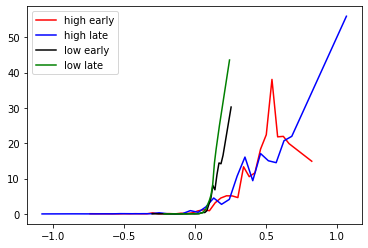

In [217]:
he, hl, le, ll = contrast_adaption_nonlinear(stimulus, pred[:, 0], h_start=2000, l_start=4000)

In [200]:
test_pc

0.7995286943563756

In [3]:
device = torch.device('cuda:3')
cfg = get_custom_cfg('LNK')
model = select_model(cfg, device)
hs = get_hs_LNK(model, 1, device)

In [5]:
hs[:, 1].shape

torch.Size([1, 1])